# Predictive Analysis

In [2]:
%matplotlib inline
import pandas as pd; pd.options.display.float_format = '{:,.3f}'.format
import numpy as np
import seaborn as sns; sns.set_style("dark")
import matplotlib.pyplot as plt; plt.rcParams['figure.figsize'] = (8,6); plt.rcParams['figure.fontsize'] = (8,6)
from IPython.display import display
from pprint import pprint

from sklearn.model_selection import train_test_split

from ml_tools import make_cross_validation, make_grid_search_clf, plot_roc_curve, make_grid_search_reg

## Data Preparation

We have the data for years 2014 and 2015. As we have seen in the previous section, the distribution of the different variables in both years differ sometimes largely from each other. For this reason we have decided not to take 2014 data for training and 2015 data from testing. Instead, we will draw a random sample from the merged dataset. The test sample is 25% of the size of the whole dataset. We have 11,316 examples in total, with 8,487 allocated to the training set and 2,829 extracted for testing purposes.<br/>
The objective is to design a predictive model which can then be used to optimise the multiplier of the estimated value. We operate by first selecting a model using KFold crossvalidation with 5 folds. Then we select the three best performing models to fine-tune their hyperparameters and boost the resulting score. The tuning of the hyperparameters is also done with a crossvalidation framework with 5 folds. We first define the range of possible parameters and then select the set of hyperparameters that maximise the evaluation metric.</br>
As discussed in the previous section, price related features have an exponential distribution. For this reason, we consider the logarithm of these values to design the model.

In [3]:
def load_data(filename):
    return pd.read_csv("data/" + filename)

data2014 = pd.read_csv('data/data2014.csv').assign(year=2014)
data2015 = pd.read_csv('data/data2015.csv').assign(year=2015)
data = pd.concat([data2014, data2015], axis=0).reset_index(drop=True)

cols = ["multiplier", "EstValue", "StartPrice", "SP.EV", "Followers"]
log10 = pd.DataFrame(np.log10(data[cols].values), columns=list(map("l{}".format, cols)))
data = pd.concat([data, log10], axis=1).drop(cols, axis=1)
data.sample(5)

,LotNr,Allocate,Bank,Dealer,Liquidator,Volunteer,LotsSale,LotsCtgry,Forced,Duration,Morning,Evening,Afternoon,year,lmultiplier,lEstValue,lStartPrice,lSP.EV,lFollowers
6841,393,0,0,0,0,1,462,31,0,265,0,0,1,2014,-0.176,1.477,1.301,-0.176,0.000
8875,168,0,0,1,0,0,1329,267,0,63,0,0,1,2015,-0.046,3.000,2.954,-0.046,1.255
5226,94,0,0,0,0,1,191,149,0,64,0,0,1,2014,0.176,1.602,1.301,-0.301,1.114
4058,355,0,0,1,0,0,955,343,0,244,0,0,1,2014,0.097,1.903,1.778,-0.125,1.176
4448,896,0,0,1,0,0,955,104,0,242,0,0,1,2014,-0.167,1.398,1.176,-0.222,1.041


## Regression

Assumption:

$$(Start Price_i, Duration_i, Estimated Value_i, Period_i) \rightarrow Followers_i \rightarrow Multiplier$$

### Model selection

In [ ]:
# followers = "lFollowers"
# X, iv, y = data.drop([target_name, followers], axis=1), data[followers], data[target_name]
# X_train, X_test, iv_train, iv_test, y_train, y_test = train_test_split(X, iv, y)

In [ ]:
# from sklearn.dummy import DummyRegressor
# from sklearn.linear_model import LinearRegression, Lasso, LassoLars
# from sklearn.svm import SVR
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
# from sklearn.metrics import r2_score

# scoring = "r2"

# models = [
    
#     ("Dummy", DummyRegressor(strategy="mean")),
#     ("SVM", SVR()), 
#     ("LR", LinearRegression()),
#     ("Lasso", Lasso()),
#     ("LARS", LassoLars()),
#     ("DT", DecisionTreeRegressor()), 
#     ("RF", RandomForestRegressor()),
#     ("AB", AdaBoostRegressor()),
#     ("GB", GradientBoostingRegressor())
    
# ]

# cv_results = make_cross_validation(models, scoring, X_train, iv_train)

### Hyperparameters tuning

In [ ]:
# n_features = X_train.shape[1]

# regressors = [
#     ("LinearRegression", LinearRegression()), 
#     ("RandomForestRegressor", RandomForestRegressor(n_estimators=70)),
#     ("GradientBoostingRegressor", GradientBoostingRegressor(n_estimators=60, learning_rate=.1, max_features=9))
# ]

# reg_params = {
#     "LinearRegression": {
#         "normalize": [True, False]
#     },
    
#     "RandomForestRegressor": {
#         "criterion": ["mse", "mae"],
#         "max_features": range(5, n_features, (n_features - 5) // 3), 
#         "max_depth": range(3, 6, 2),
# #         "min_samples_split": range(5, 101, 25),
# #         "n_estimators": range(40, 80, 10)
#     },
    
#     "GradientBoostingRegressor": {
#         "min_samples_split" :   range(5, 20, 3),
# #         "max_features": range(5, n_features + 1, (n_features - 5) // 4),
#         "max_depth": range(3, 16, 4),
# #         "learning_rate": np.logspace(-2, 1, 4),
# #         "n_estimators": range(40, 80, 10)

#     },
# }

# best_models, results = make_grid_search_reg(regressors, reg_params, X_train, iv_train, X_test, iv_test)

In [ ]:
# gbr = best_models[-1]
# coef = pd.DataFrame(index=X_train.columns)
# coef["Feature Importances"] = gbr.feature_importances_
# coef.sort_values("Feature Importances", ascending=False)

## Classification

### Preprocessing

Prepare data for classification

In [4]:
final_columns = [
    'LotNr', 'Allocate', 'Bank', 'Dealer', 'Liquidator', 'Volunteer',
    'LotsSale', 'LotsCtgry', 'Forced',  'lEstValue', 'lFollowers',
    'Duration', 'Morning', 'Evening', 'Afternoon',  'lSP.EV'
]

In [5]:
target_name = "lmultiplier"
# bins = np.logspace(-2, 2, 5, base=2)
bins = np.array([-2., 0., .3, 2])

def cut(X, filter_values, log=False):
    if log: X = np.log2(X)
    X_cut = pd.cut(X, bins=filter_values)
    X_cut = X_cut.map(lambda x: np.argmax(filter_values > x.left) - 1)
    X_cut.loc[X_cut.isnull()] = X[X_cut.isnull()].map(lambda x: len(filter_values) - 2 if x > filter_values[-1] else 0)
    return X_cut

X, y = data[final_columns], data[target_name]
X_train, X_test, y_train, y_test = train_test_split(X, y)
# X_train, X_test = pd.concat([X_train, iv_train], axis=1), pd.concat([X_test, iv_test], axis=1)
y_train_bins = cut(y_train, bins, log=False)
y_test_bins = cut(y_test, bins)
# y_train_bins = y_train.map(lambda x: 0 if x <= 0 else 1)
# y_test_bins = y_test.map(lambda x: 0 if x <= 0 else 1)

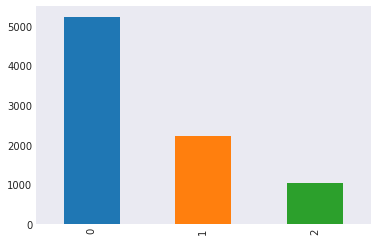

In [21]:
# fig, axs = plt.subplots(3, 2, figsize=(16,12))
for i, (series, series_bin) in enumerate(zip([y_train, y_test], [y_train_bins, y_test_bins])):
#     sns.boxplot(x=series, y=series_bin, orient='h', ax=axs[0, i % 3])
#     sns.distplot(series, hue=series_bin, ax=axs[1, i % 3])
    series_bin.value_counts().sort_index().plot.bar()  #ax=axs[2, i % 3])
#     [ax.set_xlabel("") for ax in axs[:, i % 3]]
    break
    
plt.savefig("output/class_distribution.png")

### Classification

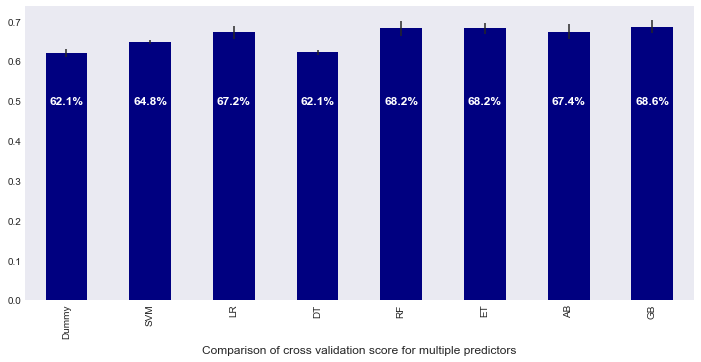

In [23]:
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    ExtraTreesClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier
)

scoring = "accuracy"

models = [
    
    ("Dummy", DummyClassifier(strategy="most_frequent")),
    ("SVM", SVC()), 
    ("LR", LogisticRegression()),
    ("DT", DecisionTreeClassifier()), 
    ("RF", RandomForestClassifier()),
    ("ET", ExtraTreesClassifier()),
    ("AB", AdaBoostClassifier()),
    ("GB", GradientBoostingClassifier())
    
]

cv_results = make_cross_validation(models, scoring, X_train, y_train_bins)
plt.savefig("Model selection.png")

In [20]:
import warnings
import pickle
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

def make_grid_search_multiclass(classifiers, clf_params, X_train, y_train, X_test, y_test, random=False, search_kw=None, save=True):
    average, scorer = "weighted", "f1_macro"
    
    best_models, scores = [], []
    results = pd.DataFrame(index=[item[0] for item in classifiers],
                           columns=["name", "params", "accuracy", "auc_score_tr", "auc_score_te",
                                    "precision", "recall", "fscore", "support", "TP", "FP", "FN", "TN"])

    if random:
        SearchCV = RandomizedSearchCV
    else:
        SearchCV = GridSearchCV
    if search_kw is None:
        search_kw = dict(n_jobs=-1, return_train_score=True, scoring=scorer)

    for i, (name, clf) in enumerate(classifiers):
        params = clf_params[name]
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            gs = SearchCV(clf, params, **search_kw).fit(X_train, y_train)
        best_models.append(gs.best_estimator_)
#         y_pred = gs.predict(X_test)
#         precision, recall, f_score, support = precision_recall_fscore_support(y_test, y_pred, average=average)
#         auc_score_te = roc_auc_score(y_test, y_pred, average=average)
#         auc_score_tr = gs.best_score_
#         accuracy = (y_pred == y_test).mean()
#         params = gs.best_params_
#         [[TP, FN], [FP, TN]] = confusion_matrix(y_test, y_pred)
#         results.loc[name, :] = (name, params, accuracy, auc_score_tr, auc_score_te, precision,
#                                 recall, f_score, support, TP, FP, FN, TN)

#         scores.append(roc_auc_score(y_test, y_pred))
#         gs_results = pd.DataFrame(gs.cv_results_).drop("params", axis=1).sort_values("rank_test_score")
#         print("\n{}:\n".format(name))
#         print("\tAccuracy: {:.2%}".format(accuracy))
#         print("\tAUC Score (Train set): {:.2%}".format(gs.best_score_))
#         print("\tAUC Score (Test set): {:.2%}\n".format(scores[-1]))
#         print(classification_report(y_test, y_pred))
#         print(best_models[-1], "\n")
#         if i + 1 < len(classifiers):
#             print("#" * 100)
#     fig = plt.figure(figsize=(12, 6))
#     ax = fig.add_subplot(111)
#     results.plot.bar(ax=ax)
    if save:
        pickle_models(best_models)
    return best_models #, results

def pickle_models(models):

    for model in models:
        name = str(model.__class__).split(".")[-1][:-2]
        with open(f"output/{name}.pkl", 'wb') as f:
            pickle.dump(model, f)

In [21]:
n_features = X_train.shape[1]

base_dt = DecisionTreeClassifier(criterion='entropy', splitter='random')  #max_features="auto", max_depth=None)

classifiers = [
    ("LogisticRegression", LogisticRegression()), 
    ("AdaBoostClassifier", AdaBoostClassifier(base_estimator=base_dt, learning_rate=0.01, n_estimators=60)),
    ("GradientBoostingClassifier", GradientBoostingClassifier(n_estimators=60, learning_rate=0.1))
]

clf_params = {
    "LogisticRegression": {
#         "penalty": ["l1", "l2"], 
        "C": np.logspace(-3, 3, 7), 
        "class_weight":["balanced", None]
    },
    
    "AdaBoostClassifier": {
#         "base_estimator__criterion" : ["gini", "entropy"],
#         "base_estimator__splitter" :   ["best", "random"],
        "base_estimator__max_features": range(5, n_features + 1, (n_features - 5) // 4),
        "base_estimator__max_depth": range(3, 16, 4),
#         "learning_rate": np.logspace(-2, 1, 4),
#         "n_estimators": range(40, 80, 10)
    },
    
    "GradientBoostingClassifier": {
        "min_samples_split" :   range(3, 10, 3),
        "max_features": range(5, n_features + 1, (n_features - 5) // 4),
        "max_depth": range(3, 16, 4),
#         "learning_rate": np.logspace(-2, 1, 4),
#         "n_estimators": range(40, 80, 10)

    },
}

best_models = make_grid_search_multiclass(classifiers, clf_params, X_train, y_train_bins, X_test, y_test_bins)

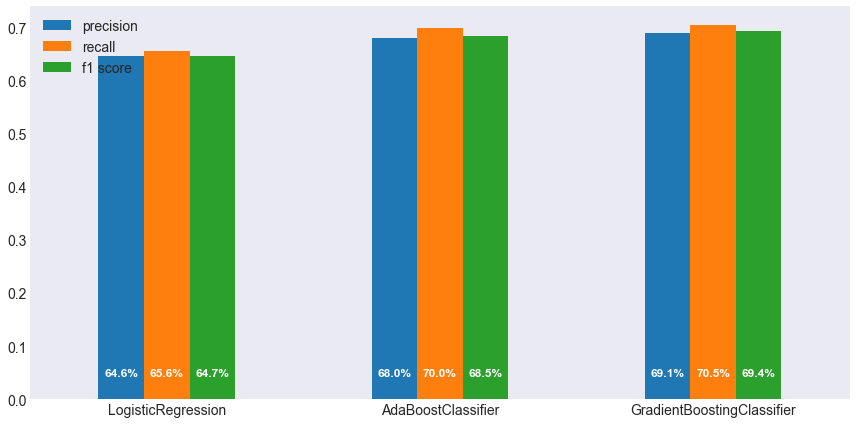

In [45]:
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    roc_curve
)

def label_barchart(ax, fmt="{:.1%}"):
    text_settings = dict(fontsize=12, fontweight='bold', color="White")
    rects = ax.patches
    for i, rect in enumerate(rects):
        x_pos = rect.get_x() + rect.get_width() / 2
        label = fmt.format(rect.get_height())
        ax.text(x_pos, .05, label, ha='center', va='center', **text_settings)


metrics = [
#     ("accuracy_score", accuracy_score),
    ("precision_recall_fscore_support", precision_recall_fscore_support),
#     ("roc_auc_score", roc_auc_score),
#     ("confusion_matrix", confusion_matrix),
#     classification_report,
#     roc_curve
]

results = pd.DataFrame(index=["precision", "recall", "f1 score"])

for model in best_models:
    y_pred = model.predict(X_test)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test_bins, y_pred, average="weighted")
    name = str(model.__class__).split(".")[-1][:-2]

    results[name] = [precision, recall, f1]
#     for name, metric in metrics:
#         print(name, end=": ")
#         print(metric(y_test_bins, y_pred, average="weighted"))

ax = results.T.plot.bar()
ax.get_figure().set_size_inches((12, 6))
label_barchart(ax)
# [tl.set_rotation(0) for tl in ax.get_xticklabels()]
ax.tick_params(labelrotation=0, labelsize=14)
plt.legend(fontsize=14, loc=2)
plt.tight_layout()
plt.savefig("output/tuned models.png")

In [ ]:
# plot_roc_curve(classifiers, best_models, X_test, y_test_bins)

clf = best_models[0]
coef = pd.DataFrame(index=X_train.columns)
coef["Feature Importances"] = clf.feature_importances_
coef.sort_values("Feature Importances", ascending=False)

In [10]:
import pickle

def load_model(model_name):
    with open(model_name, 'rb') as f:
        model = pickle.load(f)
    return model

# gbr = load_model("output/GradientBoostingRegressor.pkl")
adb = load_model("output/AdaBoostClassifier.pkl")
y_pred = adb.predict(X_test)
y_pred.sum()

1076

In [11]:
adb.score(X_test, y_test_bins)

0.7104984093319194

## Classifier Visualizations

In [15]:
X_test.sample(5)

,LotNr,Allocate,Bank,Dealer,Liquidator,Volunteer,LotsSale,LotsCtgry,Forced,lEstValue,lFollowers,Duration,Morning,Evening,Afternoon,lSP.EV
6076,1113,0,0,1,0,0,1426,778,0,1.398,0.954,39,0,0,1,-0.097
5991,1002,0,0,1,0,0,1426,778,0,1.398,1.041,40,0,0,1,-0.097
10374,766,0,0,1,0,0,1079,360,0,1.176,0.845,319,0,0,1,-0.176
9071,650,0,0,1,0,0,1329,630,0,1.544,1.342,64,0,0,1,-0.146
11230,58,0,0,0,0,1,162,140,1,2.097,0.954,456,0,0,1,-0.222


In [16]:
def merge_columns(df, columns):
    return (
        df[columns]
        .stack()
        .reset_index()
        .set_index('level_0')
        .where(lambda df: df[0] != 0)
        .dropna()
        .drop(0, axis=1)
    )
#Creating the dataframe to visualize classifier performance
df_vis = X_test[['lSP.EV','Duration','Morning','Evening','Afternoon']].copy()
df_vis['lmultiplier'] = y_test
df_vis['Prediction'] = adb.predict(X_test)
df_vis['Actual'] = y_test_bins
df_vis['Mask']= df_vis['Prediction'] != df_vis['Actual']
day_period = merge_columns(df_vis, ['Morning', 'Afternoon', 'Evening'])
df_vis['Day Period'] = day_period['level_1']
#df_vis["day_period"]=merge_columns(df_vis, ['Morning', 'Afternoon', 'Evening']),

#df_vis['Actual'] = df_vis['lmultiplier'].apply()
df_vis.sample(10)



,lSP.EV,Duration,Morning,Evening,Afternoon,lmultiplier,Prediction,Actual,Mask,Day Period
3841,-0.196,242,0,0,1,0.464,2,2,False,Afternoon
2496,-0.176,438,0,0,1,0.000,0,0,False,Afternoon
7598,-0.222,362,0,0,1,0.571,2,2,False,Afternoon
6428,-0.211,39,0,0,1,0.090,0,1,True,Afternoon
2446,-0.301,439,0,0,1,0.000,0,0,False,Afternoon
7030,-0.125,340,0,0,1,0.882,0,2,True,Afternoon
5991,-0.097,40,0,0,1,-0.097,0,0,False,Afternoon
1181,-0.204,39,0,0,1,0.176,0,1,True,Afternoon
852,-0.204,44,0,1,0,0.140,0,1,True,Evening
4087,-0.125,244,0,0,1,-0.125,1,0,True,Afternoon


Joint plot of lmultiplier and ISP.EV with hue = not predicted

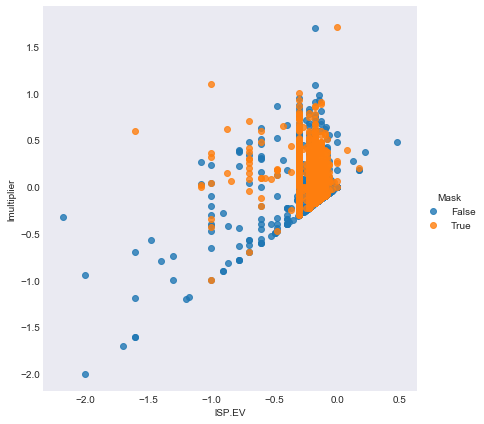

In [19]:
#jointplot of multiplier  and lSP.EV with hue incorectly predicted 
#g = sns.jointplot(x='lSP.EV', y='lmultiplier',data = df_vis, kind='reg', size=8, hue = 'Mask')
g = sns.lmplot(x='lSP.EV', y='lmultiplier',data = df_vis, size=6, hue = 'Mask', fit_reg=False)
#x = np.linspace(-2.5, .5, 100);
#g.ax_joint.plot(x, x, c='darkgrey', zorder=0)
#g.ax_joint.axhline(y=0, c='crimson', zorder=0); g.ax_joint.axvline(x=0, c='crimson', zorder=0);

plt.savefig('Multiplier to SP.EV log conigured.png')

Joint plot of Duration and lmultiplier with hue = not predicted

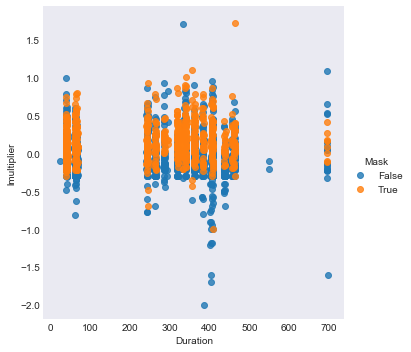

In [20]:
#jointPlot with Duration and Imultiplier with hue = Mask
#g = sns.jointplot(x='lSP.EV', y='lmultiplier',data = df_vis, kind='reg', size=8, hue = 'Mask')
g = sns.lmplot(x='Duration', y='lmultiplier',data = df_vis, size=5, hue = 'Mask', fit_reg=False)
#x = np.linspace(-2.5, .5, 100);
#g.ax_joint.plot(x, x, c='darkgrey', zorder=0)
#g.ax_joint.axhline(y=0, c='crimson', zorder=0); g.ax_joint.axvline(x=0, c='crimson', zorder=0);

plt.savefig('Multiplier to SP.EV log conigured.png')

Joint plot of lmultiplier and day period with hue = not predicted

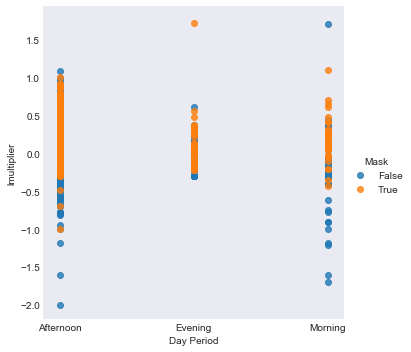

In [21]:
#Jointplot for time of the day
g = sns.lmplot(x='Day Period', y='lmultiplier',data = df_vis, size=5, hue = 'Mask', fit_reg=False)

Box plot of lSP.EV and y test with hue = not predicted

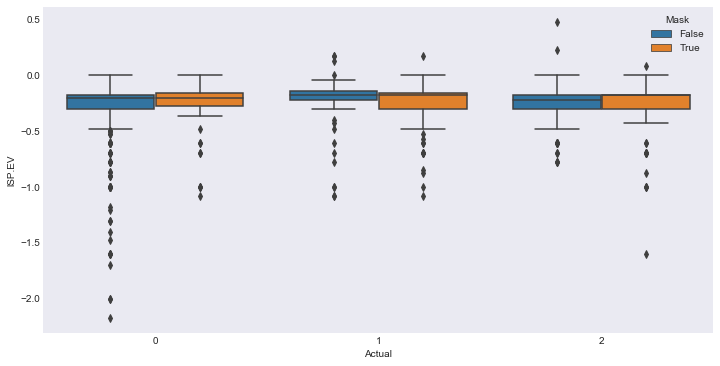

In [22]:
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
ax = sns.boxplot(x='Actual',y='lSP.EV', hue='Mask', data=df_vis)
ax.get_figure().set_size_inches((12,6))
# sns.boxplot(x='Prediction',y='lSP.EV', data=df_vis, ax=ax2)